# COMPAS Fairness Audit using AI Fairness 360
This notebook audits the COMPAS dataset for racial bias using IBM's AI Fairness 360 toolkit.

In [1]:
 !pip install aif360

  Attempting uninstall: joblib
    Found existing installation: joblib 0.17.0
    Uninstalling joblib-0.17.0:
      Successfully uninstalled joblib-0.17.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder


## Load and Explore COMPAS Dataset

In [3]:
# Load from CSV
compas = pd.read_csv('Data/compas-scores-raw.csv')  # Use forward slash for compatibility

# Show basic info
print("Dataset shape:", compas.shape)
print("Columns:", compas.columns.tolist())

# Show head
compas.head()


Dataset shape: (60843, 28)
Columns: ['Person_ID', 'AssessmentID', 'Case_ID', 'Agency_Text', 'LastName', 'FirstName', 'MiddleName', 'Sex_Code_Text', 'Ethnic_Code_Text', 'DateOfBirth', 'ScaleSet_ID', 'ScaleSet', 'AssessmentReason', 'Language', 'LegalStatus', 'CustodyStatus', 'MaritalStatus', 'Screening_Date', 'RecSupervisionLevel', 'RecSupervisionLevelText', 'Scale_ID', 'DisplayText', 'RawScore', 'DecileScore', 'ScoreText', 'AssessmentType', 'IsCompleted', 'IsDeleted']


,Person_ID,AssessmentID,Case_ID,Agency_Text,LastName,FirstName,MiddleName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,...,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted
0,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,7,Risk of Violence,-2.08,4,Low,New,1,0
1,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,8,Risk of Recidivism,-1.06,2,Low,New,1,0
2,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,18,Risk of Failure to Appear,15.00,1,Low,New,1,0
3,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,1,Low,7,Risk of Violence,-2.84,2,Low,New,1,0
4,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,1,Low,8,Risk of Recidivism,-1.50,1,Low,New,1,0


 # 2. Clean and Preprocess

In [4]:
# Keep relevant columns
columns = ['Person_ID', 'Sex_Code_Text', 'Ethnic_Code_Text', 'RawScore', 'DecileScore', 'ScoreText', 'AssessmentType', 'IsCompleted']
compas_clean = compas[columns]

# Drop rows with missing or irrelevant values
compas_clean = compas_clean.dropna()

# Filter out deleted or incomplete assessments
compas_clean = compas_clean[compas_clean['IsCompleted'] == 1]

# Binary label: High risk = 1, Low/Medium = 0
compas_clean['label'] = compas_clean['ScoreText'].apply(lambda x: 1 if x == 'High' else 0)

# Binary protected attribute: African-American = 1, Others = 0
compas_clean['race'] = compas_clean['Ethnic_Code_Text'].apply(lambda x: 1 if x == 'African-American' else 0)

compas_clean[['Ethnic_Code_Text', 'ScoreText', 'label', 'race']].head()


,Ethnic_Code_Text,ScoreText,label,race
0,Caucasian,Low,0,0
1,Caucasian,Low,0,0
2,Caucasian,Low,0,0
3,Caucasian,Low,0,0
4,Caucasian,Low,0,0


In [8]:
# Preview categorical columns
print(compas_clean.select_dtypes(include='object').columns)

Index(['Sex_Code_Text', 'Ethnic_Code_Text', 'ScoreText', 'AssessmentType'], dtype='object')


In [29]:
# Label encode all object (categorical string) columns
le = LabelEncoder()
for col in compas_clean.select_dtypes(include='object').columns:
    compas_clean[col] = le.fit_transform(compas_clean[col])


# 3. Convert to AIF360 Dataset


In [35]:
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing

# Define privileged and unprivileged groups
privileged_groups = [{'Ethnic_Code_Text': 'Caucasian'}]
unprivileged_groups = [{'Ethnic_Code_Text': 'African-American'}]  # Adjust if needed

# Filter necessary columns
features = ['Ethnic_Code_Text', 'DecileScore']
df_filtered = compas_clean[features].copy()

# Assign binary labels: 1 = high risk, 0 = low risk
df_filtered['label'] = df_filtered['DecileScore'].apply(lambda x: 1 if x > 4 else 0)  # adjust threshold

# Create BinaryLabelDataset
compas_aif = BinaryLabelDataset(
    df=df_filtered,
    label_names=['label'],
    protected_attribute_names=['Ethnic_Code_Text'],
    favorable_label=0,
    unfavorable_label=1
)



## Assess Fairness Metrics

In [32]:
metric = BinaryLabelDatasetMetric(
    compas_aif,
    unprivileged_groups=[{'race': 0}],
    privileged_groups=[{'race': 1}]
)

print("Disparate Impact:", metric.disparate_impact())
print("Statistical Parity Difference:", metric.statistical_parity_difference())

Disparate Impact: 1.1206567510218353
Statistical Parity Difference: 0.10038344980762637


## Apply Reweighing to Mitigate Bias

In [37]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

compas_transf = RW.fit_transform(compas_aif)


## Visualize False Positive Rates by Race

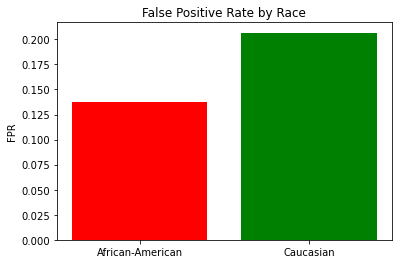

In [44]:
preds = df_filtered['DecileScore'].values
true =  df_filtered['label'].values
race = df_filtered['Ethnic_Code_Text'].values
        

# False positives
false_positives = (preds == 1) & (true == 0)

# You may need to check your race categories and map accordingly
# For example: 0 = African-American, 1 = Caucasian (adjust if needed)
african_american_fp = np.mean(false_positives[race == 0])
caucasian_fp = np.mean(false_positives[race == 1])

# Plot
plt.bar(['African-American', 'Caucasian'], [african_american_fp, caucasian_fp], color=['red', 'green'])
plt.title("False Positive Rate by Race")
plt.ylabel("FPR")
plt.show()
